In [16]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten,GlobalAveragePooling2D
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression


In [4]:
train_dir = r"C:\Users\Admin\Downloads\BoneFractureDataset\training"
test_dir = r"C:\Users\Admin\Downloads\BoneFractureDataset\testing"

In [8]:
from tensorflow.keras import layers, models    #Unable to include squeezenet from github

def SqueezeNet(input_shape=(224, 224, 3), classes=1000):
    inputs = layers.Input(shape=input_shape)
    
    # Initial convolution
    x = layers.Conv2D(96, (7, 7), strides=(2, 2), padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Fire modules
    def fire_module(x, squeeze_filters, expand_filters):
        squeeze = layers.Conv2D(squeeze_filters, (1, 1), padding='same', activation='relu')(x)
        expand1 = layers.Conv2D(expand_filters, (1, 1), padding='same', activation='relu')(squeeze)
        expand2 = layers.Conv2D(expand_filters, (3, 3), padding='same', activation='relu')(squeeze)
        return layers.concatenate([expand1, expand2], axis=-1)

    x = fire_module(x, 16, 64)
    x = fire_module(x, 16, 64)
    x = fire_module(x, 32, 128)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = fire_module(x, 32, 128)
    x = fire_module(x, 48, 192)
    x = fire_module(x, 48, 192)
    x = fire_module(x, 64, 256)
    
    # Global average pooling and classifier
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

# Create SqueezeNet model
squeeze_model = SqueezeNet(input_shape=(224, 224, 3), classes=len(train_generator.class_indices))


In [6]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load images and labels from the training directory
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

# Load images and labels from the testing directory
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary', 
    shuffle=False
)


Found 8863 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [11]:
#Creating a model 
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg_model = Model(inputs=vgg_model.input, outputs=GlobalAveragePooling2D()(vgg_model.output))

# Extract features using VGG16
train_features_vgg = vgg_model.predict(train_generator)
test_features_vgg = vgg_model.predict(test_generator)

C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


277/277 ━━━━━━━━━━━━━━━━━━━━ 1490s 5s/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 97s 5s/step


In [14]:
#since the model is custom model , we need to pop out the top layer for feature extarction
feature_extractor = models.Model(inputs=squeeze_model.input, outputs=squeeze_model.layers[-2].output)

train_features = feature_extractor.predict(train_generator)
test_features = feature_extractor.predict(test_generator)

# Get labels
train_labels = train_generator.classes
test_labels = test_generator.classes

277/277 ━━━━━━━━━━━━━━━━━━━━ 152s 548ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step


In [21]:
# Training on VGG16 features
X_train_vgg, X_val_vgg, y_train_vgg, y_val_vgg = train_test_split(train_features_vgg, train_labels, test_size=0.2, random_state=42)

print("Training on VGG16 Features")
# Random Forest
rf_model_vgg = RandomForestClassifier(n_estimators=100, random_state=42)
train_and_evaluate_model(rf_model_vgg, X_train_vgg, y_train_vgg, test_features_vgg, test_labels, "Random Forest (VGG16)")

# Support Vector Machine
svm_model_vgg = SVC(random_state=42)
train_and_evaluate_model(svm_model_vgg, X_train_vgg, y_train_vgg, test_features_vgg, test_labels, "SVM (VGG16)")

# K-Nearest Neighbors
knn_model_vgg = KNeighborsClassifier(n_neighbors=5)
train_and_evaluate_model(knn_model_vgg, X_train_vgg, y_train_vgg, test_features_vgg, test_labels, "KNN (VGG16)")

# Logistic Regression
lr_model_vgg = LogisticRegression(max_iter=1000)
train_and_evaluate_model(lr_model_vgg, X_train_vgg, y_train_vgg, test_features_vgg, test_labels, "Logistic Regression (VGG16)")


Training on VGG16 Features
Random Forest (VGG16) Test Accuracy: 0.53
              precision    recall  f1-score   support

           0       0.62      0.57      0.59       360
           1       0.42      0.47      0.44       240

    accuracy                           0.53       600
   macro avg       0.52      0.52      0.52       600
weighted avg       0.54      0.53      0.53       600

SVM (VGG16) Test Accuracy: 0.6
              precision    recall  f1-score   support

           0       0.60      1.00      0.75       360
           1       0.00      0.00      0.00       240

    accuracy                           0.60       600
   macro avg       0.30      0.50      0.38       600
weighted avg       0.36      0.60      0.45       600

KNN (VGG16) Test Accuracy: 0.49666666666666665
              precision    recall  f1-score   support

           0       0.60      0.48      0.53       360
           1       0.40      0.52      0.45       240

    accuracy                       

C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

Logistic Regression (VGG16) Test Accuracy: 0.475
              precision    recall  f1-score   support

           0       0.56      0.59      0.57       360
           1       0.33      0.31      0.32       240

    accuracy                           0.47       600
   macro avg       0.45      0.45      0.45       600
weighted avg       0.47      0.47      0.47       600



In [22]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
dt_model_vgg = DecisionTreeClassifier(random_state=42)
train_and_evaluate_model(dt_model_vgg, X_train_vgg, y_train_vgg, test_features_vgg, test_labels, "Decision Tree (VGG16)")

# Naive Bayes
nb_model_vgg = GaussianNB()
train_and_evaluate_model(nb_model_vgg, X_train_vgg, y_train_vgg, test_features_vgg, test_labels, "Naive Bayes (VGG16)")

# Gradient Boosting
gb_model_vgg = GradientBoostingClassifier(random_state=42)
train_and_evaluate_model(gb_model_vgg, X_train_vgg, y_train_vgg, test_features_vgg, test_labels, "Gradient Boosting (VGG16)")

# Extra Trees
et_model_vgg = ExtraTreesClassifier(n_estimators=100, random_state=42)
train_and_evaluate_model(et_model_vgg, X_train_vgg, y_train_vgg, test_features_vgg, test_labels, "Extra Trees (VGG16)")

Decision Tree (VGG16) Test Accuracy: 0.59
              precision    recall  f1-score   support

           0       0.70      0.55      0.62       360
           1       0.49      0.65      0.56       240

    accuracy                           0.59       600
   macro avg       0.60      0.60      0.59       600
weighted avg       0.62      0.59      0.59       600

Naive Bayes (VGG16) Test Accuracy: 0.4716666666666667
              precision    recall  f1-score   support

           0       0.55      0.68      0.61       360
           1       0.25      0.16      0.20       240

    accuracy                           0.47       600
   macro avg       0.40      0.42      0.40       600
weighted avg       0.43      0.47      0.44       600

Gradient Boosting (VGG16) Test Accuracy: 0.44
              precision    recall  f1-score   support

           0       0.53      0.52      0.53       360
           1       0.31      0.33      0.32       240

    accuracy                           0

In [12]:
#TO train on different machine learning algorithms 
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} Test Accuracy: {accuracy}")
    print(classification_report(y_test, y_pred))


In [23]:
# Train on SqueezeNet features
X_train_squeeze, X_val_squeeze, y_train_squeeze, y_val_squeeze = train_test_split(train_features, train_labels, test_size=0.2, random_state=42)

print("Training on SqueezeNet Features")
# Decision Tree
dt_model_squeeze = DecisionTreeClassifier(random_state=42)
train_and_evaluate_model(dt_model_squeeze, X_train_squeeze, y_train_squeeze, test_features, test_labels, "Decision Tree (SqueezeNet)")

# Random Forest
rf_model_squeeze = RandomForestClassifier(n_estimators=100, random_state=42)
train_and_evaluate_model(rf_model_squeeze, X_train_squeeze, y_train_squeeze, test_features, test_labels, "Random Forest (SqueezeNet)")

# Support Vector Machine
svm_model_squeeze = SVC(random_state=42)
train_and_evaluate_model(svm_model_squeeze, X_train_squeeze, y_train_squeeze, test_features, test_labels, "SVM (SqueezeNet)")

# K-Nearest Neighbors
knn_model_squeeze = KNeighborsClassifier(n_neighbors=5)
train_and_evaluate_model(knn_model_squeeze, X_train_squeeze, y_train_squeeze, test_features, test_labels, "KNN (SqueezeNet)")

# Logistic Regression
lr_model_squeeze = LogisticRegression(max_iter=1000)
train_and_evaluate_model(lr_model_squeeze, X_train_squeeze, y_train_squeeze, test_features, test_labels, "Logistic Regression (SqueezeNet)")

# Naive Bayes
nb_model_squeeze = GaussianNB()
train_and_evaluate_model(nb_model_squeeze, X_train_squeeze, y_train_squeeze, test_features, test_labels, "Naive Bayes (SqueezeNet)")

# Gradient Boosting
gb_model_squeeze = GradientBoostingClassifier(random_state=42)
train_and_evaluate_model(gb_model_squeeze, X_train_squeeze, y_train_squeeze, test_features, test_labels, "Gradient Boosting (SqueezeNet)")

# Extra Trees
et_model_squeeze = ExtraTreesClassifier(n_estimators=100, random_state=42)
train_and_evaluate_model(et_model_squeeze, X_train_squeeze, y_train_squeeze, test_features, test_labels, "Extra Trees (SqueezeNet)")

Training on SqueezeNet Features
Decision Tree (SqueezeNet) Test Accuracy: 0.555
              precision    recall  f1-score   support

           0       0.63      0.61      0.62       360
           1       0.45      0.47      0.46       240

    accuracy                           0.56       600
   macro avg       0.54      0.54      0.54       600
weighted avg       0.56      0.56      0.56       600

Random Forest (SqueezeNet) Test Accuracy: 0.5416666666666666
              precision    recall  f1-score   support

           0       0.62      0.61      0.61       360
           1       0.43      0.45      0.44       240

    accuracy                           0.54       600
   macro avg       0.53      0.53      0.53       600
weighted avg       0.54      0.54      0.54       600

SVM (SqueezeNet) Test Accuracy: 0.6
              precision    recall  f1-score   support

           0       0.60      1.00      0.75       360
           1       0.00      0.00      0.00       240

    a

C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

KNN (SqueezeNet) Test Accuracy: 0.5516666666666666
              precision    recall  f1-score   support

           0       0.64      0.59      0.61       360
           1       0.44      0.49      0.47       240

    accuracy                           0.55       600
   macro avg       0.54      0.54      0.54       600
weighted avg       0.56      0.55      0.55       600

Logistic Regression (SqueezeNet) Test Accuracy: 0.6
              precision    recall  f1-score   support

           0       0.60      1.00      0.75       360
           1       0.00      0.00      0.00       240

    accuracy                           0.60       600
   macro avg       0.30      0.50      0.38       600
weighted avg       0.36      0.60      0.45       600

Naive Bayes (SqueezeNet) Test Accuracy: 0.31833333333333336
              precision    recall  f1-score   support

           0       0.42      0.38      0.40       360
           1       0.20      0.23      0.21       240

    accuracy       

C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

Gradient Boosting (SqueezeNet) Test Accuracy: 0.6383333333333333
              precision    recall  f1-score   support

           0       0.63      0.95      0.76       360
           1       0.69      0.17      0.27       240

    accuracy                           0.64       600
   macro avg       0.66      0.56      0.52       600
weighted avg       0.66      0.64      0.57       600

Extra Trees (SqueezeNet) Test Accuracy: 0.52
              precision    recall  f1-score   support

           0       0.60      0.60      0.60       360
           1       0.40      0.40      0.40       240

    accuracy                           0.52       600
   macro avg       0.50      0.50      0.50       600
weighted avg       0.52      0.52      0.52       600



In [26]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)


Found 8863 images belonging to 2 classes.


In [27]:
# Extract images and labels
X_train_images, y_train = next(train_data)  # Load one batch as an example
X_train_images = np.concatenate([X_train_images for _ in range(len(train_data))])
y_train = np.concatenate([y_train for _ in range(len(train_data))])

# Step 2: Feature Extraction with VGG16
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg_model = Model(inputs=vgg_model.input, outputs=GlobalAveragePooling2D()(vgg_model.output))
vgg_features = vgg_model.predict(X_train_images)

277/277 ━━━━━━━━━━━━━━━━━━━━ 1450s 5s/step


In [28]:
Model_squeeze = SqueezeNet(input_shape=(224, 224, 3), classes=len(train_data.class_indices))
sq_features = Model_squeeze.predict(X_train_images)

277/277 ━━━━━━━━━━━━━━━━━━━━ 113s 390ms/step


In [29]:
features = {
    'VGG16': vgg_features,
    'SqueezeNet': sq_features
}

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier

scaler = StandardScaler()
for model_name in features:
    features[model_name] = scaler.fit_transform(features[model_name])
    # Optional: Apply PCA to reduce dimensions
    pca = PCA(n_components=0.95)
    features[model_name] = pca.fit_transform(features[model_name])

# Train Multiple Models and Store Accuracies
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'KNN': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Extra Trees': ExtraTreesClassifier(random_state=42),
}

# Accuracy dictionary to store results for plotting
accuracies = {model_name: {} for model_name in features.keys()}

# Train each model on features from VGG16 and SqueezeNet
for model_name, X_train_features in features.items():
    X_train, X_test, y_train_split, y_test_split = train_test_split(X_train_features, y_train, test_size=0.2, random_state=42)
    for algo_name, model in models.items():
        model.fit(X_train, y_train_split)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test_split, y_pred)
        accuracies[model_name][algo_name] = accuracy



C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


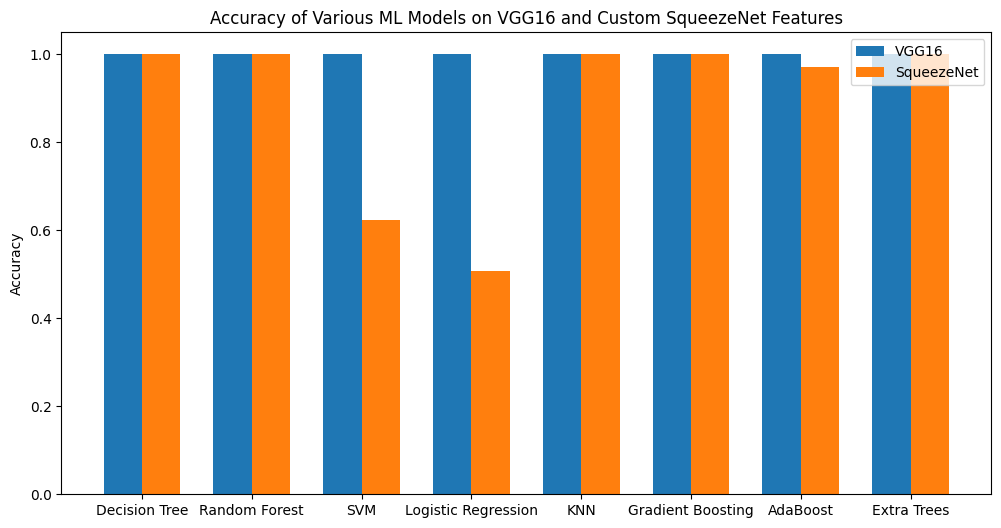

In [32]:
# Plot Accuracies
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(models))

# Plot bars for VGG16 and SqueezeNet
width = 0.35
vgg_acc = [accuracies['VGG16'][m] for m in models]
ax.bar(x - width/2, vgg_acc, width, label='VGG16')
sq_acc = [accuracies['SqueezeNet'][m] for m in models]
ax.bar(x + width/2, sq_acc, width, label='SqueezeNet')

#Add labels and title
ax.set_xticks(x)
ax.set_xticklabels(models.keys())
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy of Various ML Models on VGG16 and Custom SqueezeNet Features')
ax.legend()

plt.show()



Model: Decision Tree on VGG16 features
Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

    fractured       1.00      1.00      1.00       842
not_fractured       1.00      1.00      1.00       931

     accuracy                           1.00      1773
    macro avg       1.00      1.00      1.00      1773
 weighted avg       1.00      1.00      1.00      1773



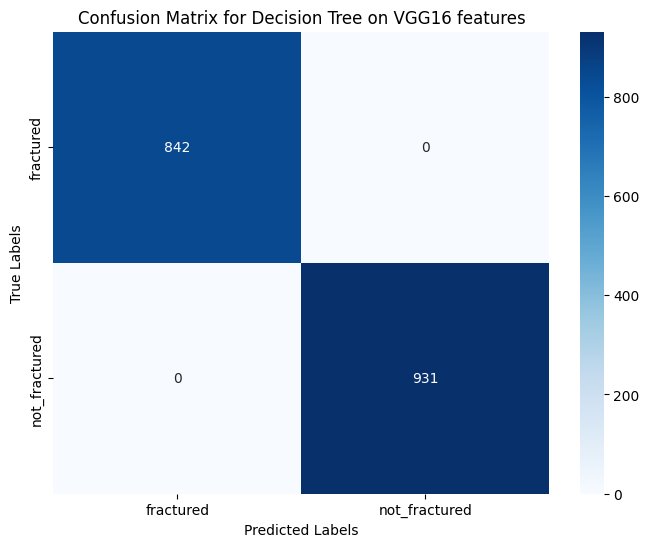


Model: Random Forest on VGG16 features
Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

    fractured       1.00      1.00      1.00       842
not_fractured       1.00      1.00      1.00       931

     accuracy                           1.00      1773
    macro avg       1.00      1.00      1.00      1773
 weighted avg       1.00      1.00      1.00      1773



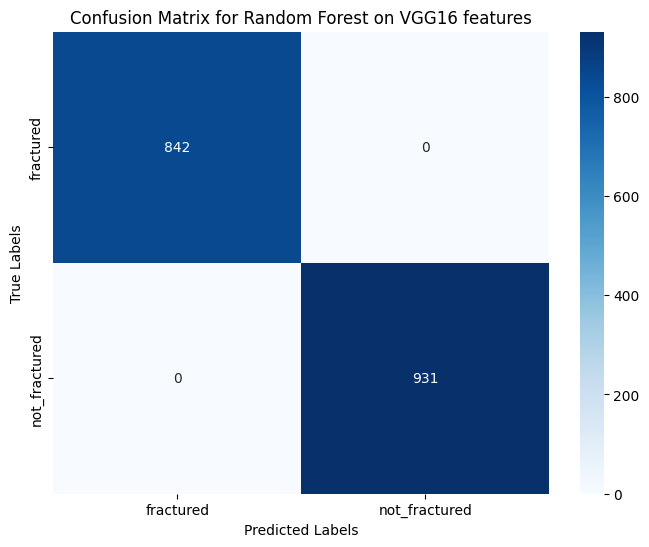


Model: SVM on VGG16 features
Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

    fractured       1.00      1.00      1.00       842
not_fractured       1.00      1.00      1.00       931

     accuracy                           1.00      1773
    macro avg       1.00      1.00      1.00      1773
 weighted avg       1.00      1.00      1.00      1773



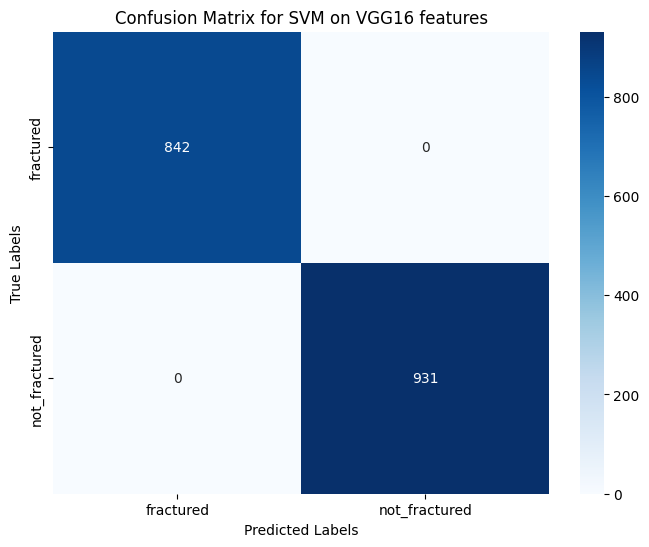


Model: Logistic Regression on VGG16 features
Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

    fractured       1.00      1.00      1.00       842
not_fractured       1.00      1.00      1.00       931

     accuracy                           1.00      1773
    macro avg       1.00      1.00      1.00      1773
 weighted avg       1.00      1.00      1.00      1773



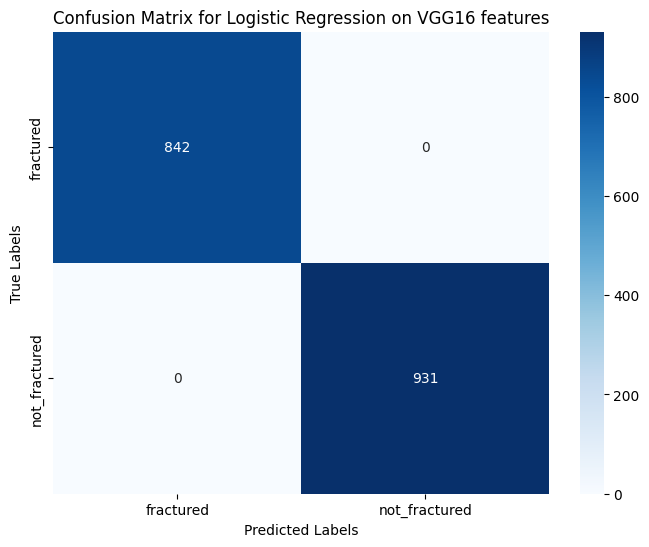


Model: KNN on VGG16 features
Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

    fractured       1.00      1.00      1.00       842
not_fractured       1.00      1.00      1.00       931

     accuracy                           1.00      1773
    macro avg       1.00      1.00      1.00      1773
 weighted avg       1.00      1.00      1.00      1773



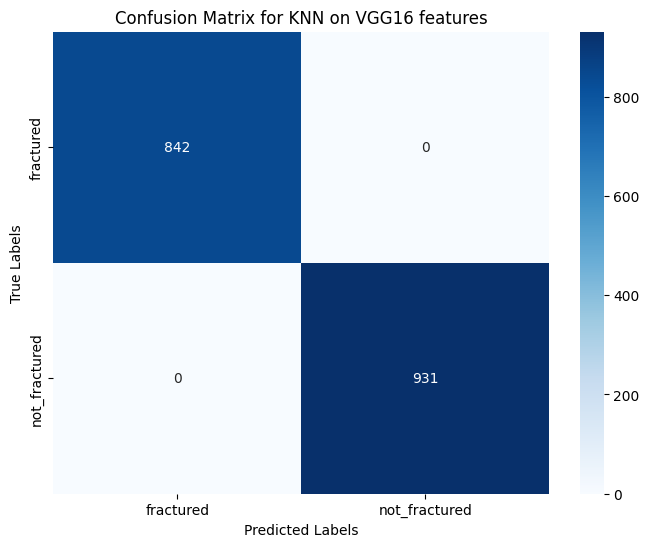


Model: Gradient Boosting on VGG16 features
Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

    fractured       1.00      1.00      1.00       842
not_fractured       1.00      1.00      1.00       931

     accuracy                           1.00      1773
    macro avg       1.00      1.00      1.00      1773
 weighted avg       1.00      1.00      1.00      1773



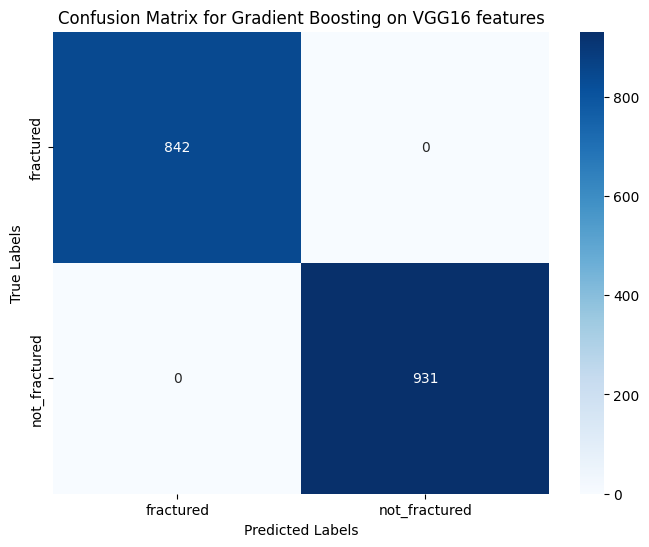

C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



Model: AdaBoost on VGG16 features
Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

    fractured       1.00      1.00      1.00       842
not_fractured       1.00      1.00      1.00       931

     accuracy                           1.00      1773
    macro avg       1.00      1.00      1.00      1773
 weighted avg       1.00      1.00      1.00      1773



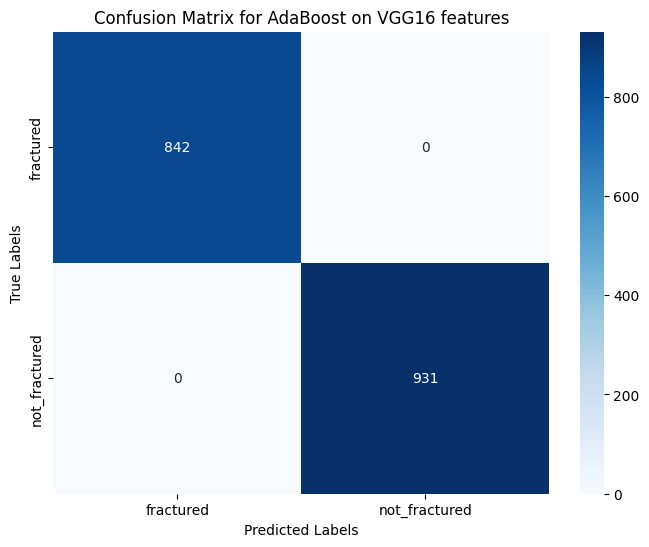


Model: Extra Trees on VGG16 features
Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

    fractured       1.00      1.00      1.00       842
not_fractured       1.00      1.00      1.00       931

     accuracy                           1.00      1773
    macro avg       1.00      1.00      1.00      1773
 weighted avg       1.00      1.00      1.00      1773



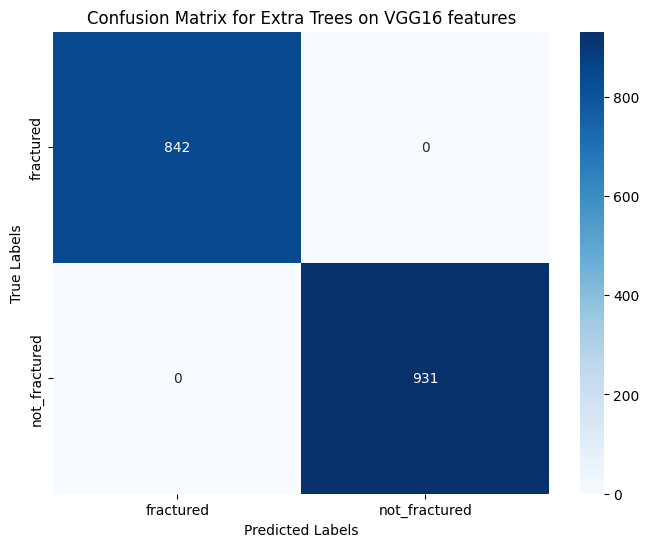


Model: Decision Tree on SqueezeNet features
Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

    fractured       1.00      1.00      1.00       842
not_fractured       1.00      1.00      1.00       931

     accuracy                           1.00      1773
    macro avg       1.00      1.00      1.00      1773
 weighted avg       1.00      1.00      1.00      1773



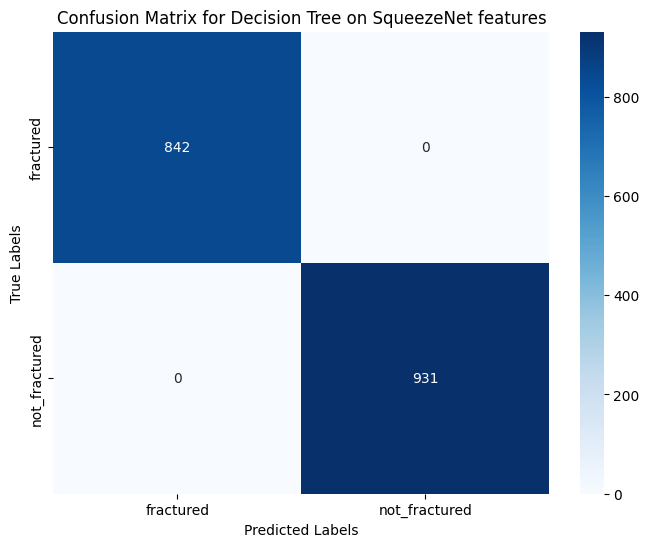


Model: Random Forest on SqueezeNet features
Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

    fractured       1.00      1.00      1.00       842
not_fractured       1.00      1.00      1.00       931

     accuracy                           1.00      1773
    macro avg       1.00      1.00      1.00      1773
 weighted avg       1.00      1.00      1.00      1773



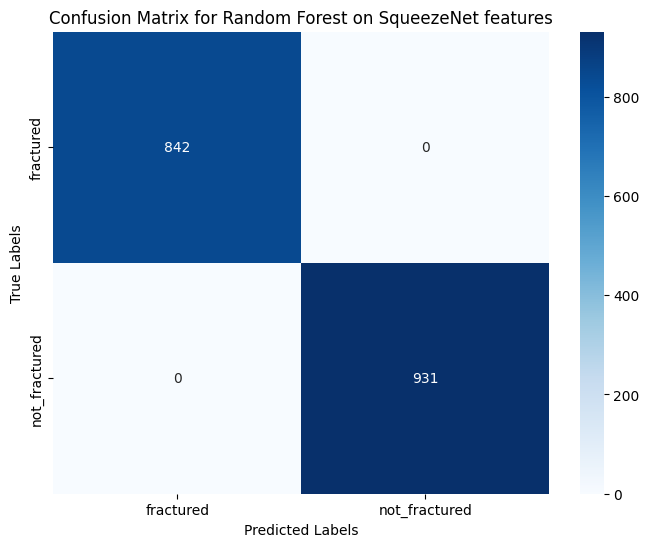


Model: SVM on SqueezeNet features
Accuracy: 0.6232
Classification Report:
               precision    recall  f1-score   support

    fractured       0.73      0.33      0.45       842
not_fractured       0.59      0.89      0.71       931

     accuracy                           0.62      1773
    macro avg       0.66      0.61      0.58      1773
 weighted avg       0.66      0.62      0.59      1773



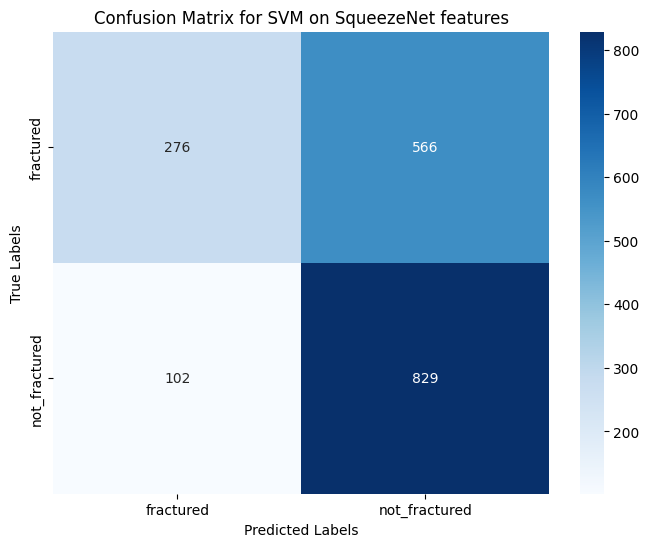


Model: Logistic Regression on SqueezeNet features
Accuracy: 0.5071
Classification Report:
               precision    recall  f1-score   support

    fractured       0.47      0.28      0.35       842
not_fractured       0.52      0.71      0.60       931

     accuracy                           0.51      1773
    macro avg       0.50      0.50      0.48      1773
 weighted avg       0.50      0.51      0.48      1773



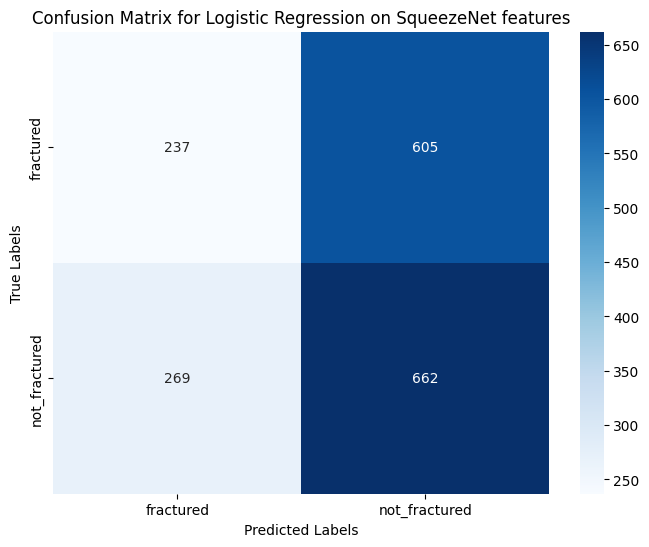


Model: KNN on SqueezeNet features
Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

    fractured       1.00      1.00      1.00       842
not_fractured       1.00      1.00      1.00       931

     accuracy                           1.00      1773
    macro avg       1.00      1.00      1.00      1773
 weighted avg       1.00      1.00      1.00      1773



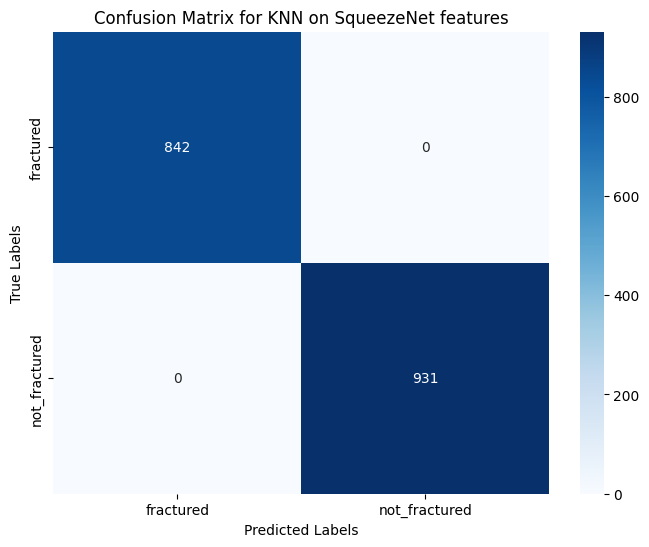


Model: Gradient Boosting on SqueezeNet features
Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

    fractured       1.00      1.00      1.00       842
not_fractured       1.00      1.00      1.00       931

     accuracy                           1.00      1773
    macro avg       1.00      1.00      1.00      1773
 weighted avg       1.00      1.00      1.00      1773



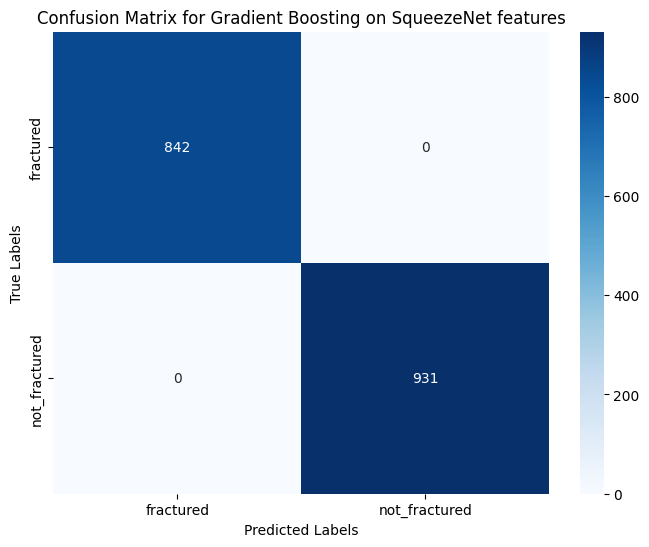

C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



Model: AdaBoost on SqueezeNet features
Accuracy: 0.9707
Classification Report:
               precision    recall  f1-score   support

    fractured       0.94      1.00      0.97       842
not_fractured       1.00      0.94      0.97       931

     accuracy                           0.97      1773
    macro avg       0.97      0.97      0.97      1773
 weighted avg       0.97      0.97      0.97      1773



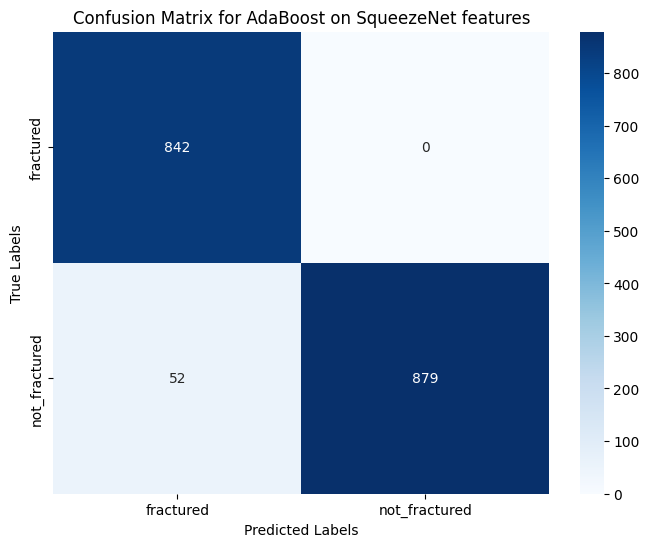


Model: Extra Trees on SqueezeNet features
Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

    fractured       1.00      1.00      1.00       842
not_fractured       1.00      1.00      1.00       931

     accuracy                           1.00      1773
    macro avg       1.00      1.00      1.00      1773
 weighted avg       1.00      1.00      1.00      1773



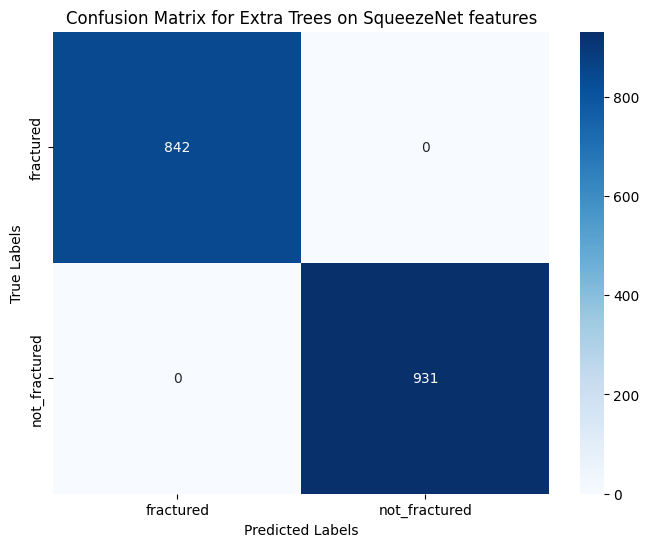

In [33]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Dictionary to store classification reports and confusion matrices
reports = {model_name: {} for model_name in features.keys()}
conf_matrices = {model_name: {} for model_name in features.keys()}

# Loop over VGG16 and SqueezeNet features
for model_name, X_train_features in features.items():
    X_train, X_test, y_train_split, y_test_split = train_test_split(X_train_features, y_train, test_size=0.2, random_state=42)
    
    # Train each model on the extracted features
    for algo_name, model in models.items():
        model.fit(X_train, y_train_split)
        y_pred = model.predict(X_test)

        # Accuracy
        accuracy = accuracy_score(y_test_split, y_pred)
        accuracies[model_name][algo_name] = accuracy

        # Classification Report
        reports[model_name][algo_name] = classification_report(y_test_split, y_pred, target_names=train_data.class_indices.keys())
        
        # Confusion Matrix
        conf_matrices[model_name][algo_name] = confusion_matrix(y_test_split, y_pred)

        # Print results for each model
        print(f"\nModel: {algo_name} on {model_name} features")
        print(f"Accuracy: {accuracy:.4f}")
        print("Classification Report:")
        print(reports[model_name][algo_name])
        
        # Plot Confusion Matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrices[model_name][algo_name], annot=True, fmt='d', cmap='Blues', xticklabels=train_data.class_indices.keys(), yticklabels=train_data.class_indices.keys())
        plt.title(f'Confusion Matrix for {algo_name} on {model_name} features')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.show()


In [34]:
from sklearn.model_selection import cross_val_score

for algo_name, model in models.items():
    # Use cross-validation on the extracted features
    cv_scores = cross_val_score(model, X_train_features, y_train, cv=5)
    print(f"{algo_name} Cross-Validation Scores: {cv_scores}")
    print(f"{algo_name} Mean CV Accuracy: {np.mean(cv_scores):.4f}")


Decision Tree Cross-Validation Scores: [1. 1. 1. 1. 1.]
Decision Tree Mean CV Accuracy: 1.0000
Random Forest Cross-Validation Scores: [1. 1. 1. 1. 1.]
Random Forest Mean CV Accuracy: 1.0000
SVM Cross-Validation Scores: [0.65595037 0.65651438 0.65651438 0.65595037 0.65632054]
SVM Mean CV Accuracy: 0.6563
Logistic Regression Cross-Validation Scores: [0.49971799 0.50028201 0.49971799 0.50028201 0.5       ]
Logistic Regression Mean CV Accuracy: 0.5000
KNN Cross-Validation Scores: [1. 1. 1. 1. 1.]
KNN Mean CV Accuracy: 1.0000
Gradient Boosting Cross-Validation Scores: [1. 1. 1. 1. 1.]
Gradient Boosting Mean CV Accuracy: 1.0000


C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use t

AdaBoost Cross-Validation Scores: [0.96897913 0.96897913 0.96841512 0.96897913 0.96839729]
AdaBoost Mean CV Accuracy: 0.9687
Extra Trees Cross-Validation Scores: [1. 1. 1. 1. 1.]
Extra Trees Mean CV Accuracy: 1.0000


In [49]:
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")


X_train_scaled shape: (7091, 1)
X_test_scaled shape: (1773, 1)
